## Exercício

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
def plot_cv_varias_metricas(estimator, X, y, n_splits, scoring):
    '''
    scoring: tupla de strings relativas às métricas
    '''
    
    kf5 = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    result_cv = cross_validate(estimator=estimator, X=X, y=y, 
                               cv=kf5, scoring=scoring,
                               return_train_score=True)
    
    # ============================

    df_result_cv = pd.DataFrame(result_cv)
    df_result_cv = df_result_cv.abs()
    
    colunas_metricas = df_result_cv.columns.tolist()[2:]

    for i in range(0, len(colunas_metricas), 2):

        display(df_result_cv[[colunas_metricas[i+1], colunas_metricas[i]]].describe())

        print(f'\nDistribuição da métrica {colunas_metricas[i+1].replace("train_", "")} de treino:')
        sns.histplot(data=df_result_cv, x=colunas_metricas[i+1], kde=True)
        plt.show()

        print(f'\nDistribuição da métrica {colunas_metricas[i].replace("test_", "")} de teste:')
        sns.histplot(data=df_result_cv, x=colunas_metricas[i], kde=True)
        plt.show()

        print("\nAs duas juntas (compare a variância!):")
        sns.histplot(data=df_result_cv, x=colunas_metricas[i+1], label="treino", kde=True)
        sns.histplot(data=df_result_cv, x=colunas_metricas[i], color="orange", label="teste", kde=True)
        plt.legend()
        plt.show()
        
        print("#"*80)
    

In [2]:
breast_cancer = pd.read_csv('breast_cancer.csv')

In [6]:
breast_cancer = breast_cancer.drop(columns="id")

In [10]:
breast_cancer['diagnosis'].value_counts(normalize=True)

B    0.627417
M    0.372583
Name: diagnosis, dtype: float64

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate


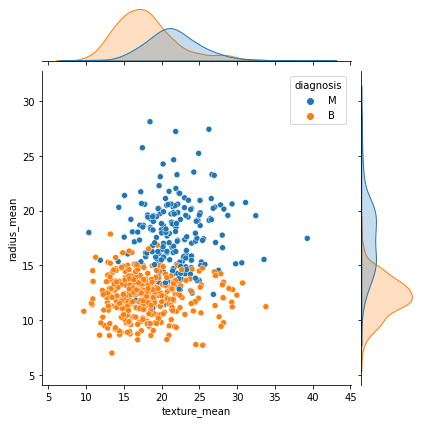

In [13]:
sns.jointplot(data=breast_cancer, x="texture_mean", y="radius_mean", hue='diagnosis')

In [26]:
X = breast_cancer.drop(columns='diagnosis')
y = breast_cancer['diagnosis']
y= y.map({"M": 1, "B":0})

C:\Users\Inspira\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Inspira\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

,train_roc_auc,test_roc_auc
count,10.000000,10.000000
mean,0.991753,0.986669
std,0.001466,0.016867
min,0.988884,0.955840
25%,0.990949,0.978472
50%,0.991904,0.995428
75%,0.992886,0.998619
max,0.993578,1.000000



Distribuição da métrica roc_auc de treino:


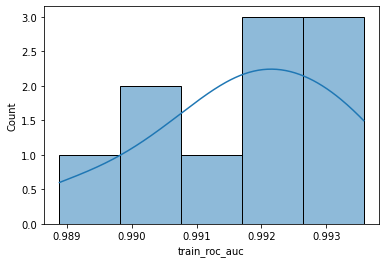


Distribuição da métrica roc_auc de teste:


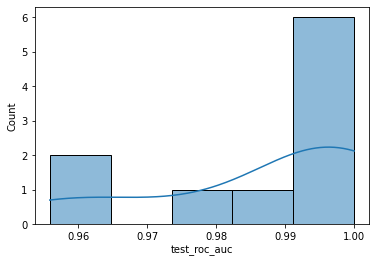


As duas juntas (compare a variância!):


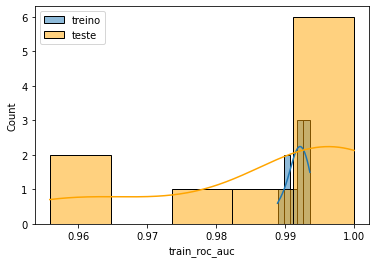

################################################################################


,train_f1,test_f1
count,10.000000,10.000000
mean,0.931538,0.919639
std,0.007801,0.048131
min,0.920548,0.810811
25%,0.925843,0.917230
50%,0.931049,0.932127
75%,0.936648,0.947794
max,0.943005,0.969697



Distribuição da métrica f1 de treino:


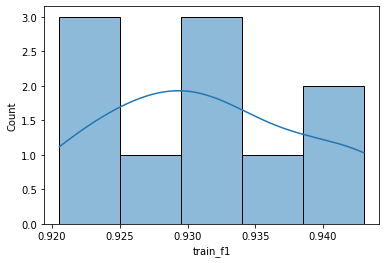


Distribuição da métrica f1 de teste:


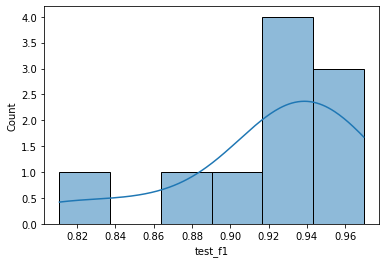


As duas juntas (compare a variância!):


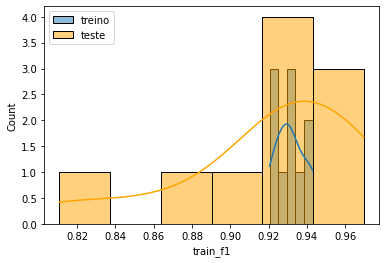

################################################################################


In [27]:
lr = LogisticRegression()

plot_cv_varias_metricas(lr, X, y, n_splits=10, scoring=('roc_auc', 'f1'))

In [25]:
y

0      M
1      M
2      M
3      M
4      M
      ..
564    M
565    M
566    M
567    M
568    B
Name: diagnosis, Length: 569, dtype: object

# Aula 4 - KNN e ferramentas especiais

Na aula de hoje, vamos explorar os seguintes tópicos em Python:

- 1) KNN
- 2) Ferramentas Especiais
- 3) KNN para regressão

____
____
____

## 1) KNN

Hoje conheceremos um novo algoritmo de aprendizagem (que inicialmente veremos no contexto de classificação): o KNN, que é a sigla de **k nearest neighbors**, ou seja, **k vizinhos mais próximos**.

A ideia é bem simples: tomamos uma base de treino classificada (supervisionada). 

A cada observação de teste que queiramos classificar, tomamos **a classe como sendo a classe das $k$ observações que estão mais próximas do elemento a ser classificado**

<img src="https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1531424125/KNN_final1_ibdm8a.png" width=600>

Este algoritmo é muito simples e intuitivo, mas há dois elementos de extrema importância:

> Como medir a **distância** entre dados? Qual é a **métrica** adequada?

Veremos que o sklearn nos permite escolher diferentes métricas de distância, o que é ótimo, pois assim podemos seguir a habitual abordagem: testar diferentes métricas, e escolher a que der melhores resultados!

> Qual é o número de vizinhos adequados: i.e., **como escolher $k$?**

Essa é uma escolha particularmente importante, pois escolhas diferentes de $k$ podem facilmente levar a classificações diferentes:

<img src="https://helloacm.com/wp-content/uploads/2016/03/2012-10-26-knn-concept.png" width=400>

Veremos logo como escolher bons valores!

> **Reflita e responda**: como a escolha de $k$ influencia a performance de generalização do modelo (isto é, seu comportamento no que diz respeito ao trade-off viés-variância)?
><br><br>Dica: pense no que acontece nos extremos, $k=1$ e $k=N$, ond $N$ é o número de observações na base de treino.

Conclusão: 

- $k=1$ temos alta variância (overfitting - pense nos outliers!).

- $k=N$ temos alto viés (underfittinf - não aprendemos nada, só predizemos diretamente a classe majoritária na base de treino).

As etapas do algoritmo são as seguintes:

1. Recebe um dado não classificado;
2. Mede sua distância (Euclidiana, Manhattan, Minkowski ou Ponderada) de cada um dos elementos da base de treino;
3. Obtém um *ranking* das distâncias, em ordem decrescente;
4. Verifica a classe de cada da um dos *K* dados que tiveram a menor distância e conta a quantidade de cada classe;
5. Toma como resultado a classe que mais apareceu dentre os dados que tiveram as menores distâncias;
6. Classifica o novo dado com a classe tomada como resultado da classificação.

KNN é um método LAZY LEARNER -- Ou seja, **não há uma etapa explícita de treinamento**, conforme vimos antes.

Cada observação de teste é classificada por vez, segundo o passo a passo acima.

> **MUITO IMPORTANTE**: sempre devemos **escalar os dados** quando formos construir um modelo KNN! Reflita: por quê?

In [2]:
# importe as principais bibliotecas

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#### Lendo conjunto de dados

Como exemplo vamos utilizar dados de câncer de mama (o dataset que foi sugerido como exercício!), eles estão disponiveis no [UCI](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) ou pelo [kaggle](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data). 

A ideia é que consigamos construir um modelo para classificar, com base em medidas fisiológicas, se um tumor é maligno ou benigno.

In [28]:
df = pd.read_csv("breast_cancer.csv")

In [29]:
df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

A coluna de ID não dá nenhuma informação relevante: podemos eliminá-la

In [31]:
df = df.drop(columns="id")

In [32]:
df

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [33]:
# dá pra ver que tem muita diferença de escala nas features! PRECISAMOS ESCALONAR!!

df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [99]:
df.isnull().sum() ## True = 1 False = 0

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

Explore os dados! Essa é uma base muito rica, com muitas colunas! Aproveite este exemplo concreto para fazer muitas perguntas e respondê-las! Faça visualizações sempre que achar interessante!

Vamos fazer um apenas pra treinar:

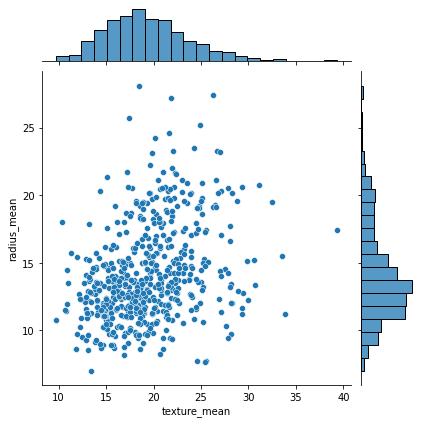

In [100]:
sns.jointplot(data=df, x="texture_mean", y="radius_mean")

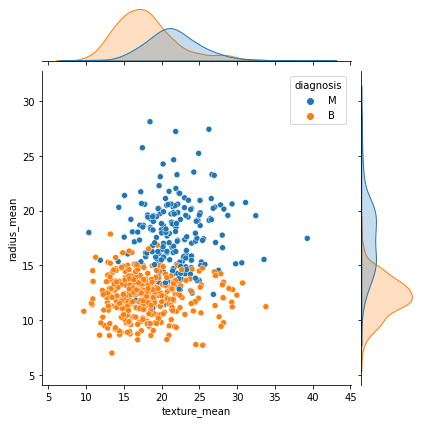

In [34]:
sns.jointplot(data=df, x="texture_mean", y="radius_mean", hue="diagnosis")

Uma pergunta é bastante importante:

In [35]:
df["diagnosis"].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [36]:
df["diagnosis"].value_counts(normalize=True)

B    0.627417
M    0.372583
Name: diagnosis, dtype: float64

<AxesSubplot:xlabel='diagnosis', ylabel='count'>

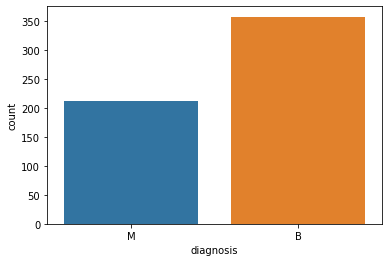

In [37]:
sns.countplot(data=df, x="diagnosis")

In [105]:
# isso equivale a usar o k=n

y_pred = df["diagnosis"].value_counts().index[0]

y_pred

'B'

Há um leve desbalanceamento: há mais dados de tumores benignos do que malignos. 

Como o desbalanceamento não é tão gritante assim (coisa de 80-20), e este desbalanço é algo natural, não vamos tratar este caso, vamos deixar para tratar um caso mais crítico.

[Clique aqui](https://machinelearningmastery.com/what-is-imbalanced-classification/) para saber um pouco mais sobre desbalanceamento de classes; e [aqui](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/) caso você queira saber algumas formas de endereçar este problema (spoilers!).

Uma coisa importante é sempre setar o parâmetro `stratify` do train-test split, que vai garantir a mesma distribuição do target em ambos os conjuntos de treino e de teste! Isso faz com que a diferença na distribuição não se torne um fator adicional de viés na avaliação do modelo!

In [109]:
X = df.drop(columns="diagnosis")
y = df["diagnosis"]

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
y.value_counts(normalize=True)

B    0.627417
M    0.372583
Name: diagnosis, dtype: float64

In [110]:
# atenção ao stratify!
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42,
                                                    stratify=y)

In [45]:
y_train.value_counts(normalize=True)

B    0.626374
M    0.373626
Name: diagnosis, dtype: float64

In [46]:
y_test.value_counts(normalize=True)

B    0.631579
M    0.368421
Name: diagnosis, dtype: float64

_____

**Transformando os dados**

O primeiro processo que pode ser feito para tunning do KNN é a **transformação das features**. 

Devido ao KNN utilizar **distâncias** como critério para classificação, ter as variaveis transformadas garante que sejam eliminados viéses relacionados à escala dos dados.

Para **normalizar os dados**, o sklearn nos apresenta a ferramenta [standard scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

É **muito importante** que os transformers sejam fitados **com os dados de treino**, para que informações da base de teste não sejam utilizadas no treinamento (conceito conhecido como [data leakage](https://machinelearningmastery.com/data-preparation-without-data-leakage/)).

No caso do standard scaler: o objetivo do `.fit()` é determinar a média $\mu$ e desvio padrão $\sigma$ dos dados, para que a normalização seja feita. Se calcularmos estes parâmetros usando **todos os dados**, estamos utilizando informações da base de teste -- o que, como sabemos, jamais deve ser feito!!

Por isso, sempre siga o seguinte passo-a-passo par aplicação de transformers:

- Primeiro, faça o train test split;
- Use o `.fit()` nos dados de **treino**;
- Use o `.transform()` pra trasnformar os dados de treino e de teste tbm -- com o **mesmo transformer treinado** com os dados de treino;

Começaremos com o  [standard scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) - **média 0 e std 1**

In [117]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler().fit(X_train) ## Está aprendendo como normalizar esses dados

## Usamos o scaler para transformar os dados de treino e teste
X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

In [118]:
## ESTA CELULA GERA RESULTADO IDENTICO A DE CIMA

# ss = StandardScaler()

# X_train_ss = ss.fit_transform(X_train)
# X_test_ss = ss.transform(X_test)

In [119]:
X_train.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,...,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,14.166077,19.417692,92.215868,659.578242,0.095993,0.103835,0.089184,0.049015,0.181497,0.062715,...,16.351514,25.904879,107.860484,890.569231,0.132083,0.255529,0.275166,0.115491,0.291364,0.084124
std,3.579081,4.290653,24.717118,360.418686,0.014310,0.053910,0.081698,0.039686,0.027646,0.006971,...,4.901037,6.079532,34.176019,582.346181,0.023481,0.158400,0.212066,0.066844,0.063043,0.018169
min,6.981000,9.710000,43.790000,143.500000,0.062510,0.019380,0.000000,0.000000,0.106000,0.050240,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.710000,16.335000,75.235000,420.400000,0.085130,0.063735,0.029520,0.019685,0.162050,0.057635,...,13.020000,21.490000,84.135000,516.150000,0.114550,0.147750,0.119350,0.064075,0.251200,0.071365
50%,13.340000,18.900000,86.180000,546.400000,0.095240,0.092280,0.059400,0.033340,0.179900,0.061300,...,14.920000,25.480000,97.650000,683.400000,0.131100,0.216700,0.229800,0.101000,0.282300,0.080090
75%,15.935000,21.830000,104.500000,795.500000,0.104900,0.130350,0.132200,0.074075,0.195400,0.066370,...,19.185000,30.200000,127.000000,1122.500000,0.146600,0.338100,0.385700,0.162100,0.318700,0.092085
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [120]:
# tivemos que transformar num dataframe, pq o std scaler retorna arrays do numpy, que não têm o metodo describe

pd.DataFrame(X_train_ss, columns=X_train.columns).describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,...,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02
mean,-1.737316e-16,3.904081e-16,4.704418e-16,-1.171224e-16,1.093143e-16,-1.991081e-16,-1.795877e-16,3.416071e-17,-1.561632e-17,1.561632e-17,...,-3.962642e-16,2.186285e-16,-2.986622e-16,-1.561632e-17,-2.030122e-16,-1.327388e-16,-5.856121e-17,-8.881784e-17,-5.153387e-16,-2.635255e-16
std,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,...,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00
min,-2.009730e+00,-2.265011e+00,-1.961360e+00,-1.433461e+00,-2.342455e+00,-1.568307e+00,-1.092835e+00,-1.236420e+00,-2.733834e+00,-1.791603e+00,...,-1.720204e+00,-2.286387e+00,-1.682868e+00,-1.212587e+00,-2.596976e+00,-1.442492e+00,-1.298977e+00,-1.729670e+00,-2.141576e+00,-1.602524e+00
25%,-6.869865e-01,-7.192578e-01,-6.877646e-01,-6.643427e-01,-7.599676e-01,-7.446452e-01,-7.311067e-01,-7.398554e-01,-7.042022e-01,-7.295506e-01,...,-6.805052e-01,-7.269867e-01,-6.949785e-01,-6.436573e-01,-7.475060e-01,-6.811748e-01,-7.355618e-01,-7.700379e-01,-6.377821e-01,-7.030095e-01
50%,-2.310610e-01,-1.207886e-01,-2.444667e-01,-3.143644e-01,-5.267576e-02,-2.145711e-01,-3.649669e-01,-3.954004e-01,-5.783428e-02,-2.031921e-01,...,-2.924054e-01,-6.996374e-02,-2.990905e-01,-3.561409e-01,-4.191078e-02,-2.454053e-01,-2.141609e-01,-2.170230e-01,-1.439281e-01,-2.222582e-01
75%,4.947835e-01,5.628428e-01,4.975359e-01,3.775369e-01,6.231343e-01,4.923801e-01,5.271006e-01,6.321626e-01,5.034376e-01,5.249492e-01,...,5.787764e-01,7.072664e-01,5.606441e-01,3.987080e-01,6.189186e-01,5.218523e-01,5.217957e-01,6.980537e-01,4.340876e-01,4.386715e-01
max,3.900239e+00,4.634299e+00,3.899731e+00,5.114742e+00,4.715773e+00,4.485809e+00,4.137033e+00,3.838961e+00,4.435961e+00,4.987148e+00,...,4.021630e+00,3.891934e+00,4.198771e+00,5.782013e+00,3.859114e+00,5.071677e+00,4.611335e+00,2.628551e+00,5.914120e+00,6.798089e+00


De fato, após o scaling, temos média zero e desvio padrão 1!

In [121]:
ss.mean_

array([1.41660769e+01, 1.94176923e+01, 9.22158681e+01, 6.59578242e+02,
       9.59929451e-02, 1.03834857e-01, 8.91842829e-02, 4.90145978e-02,
       1.81497143e-01, 6.27148132e-02, 4.11187253e-01, 1.21788198e+00,
       2.91156879e+00, 4.12791033e+01, 6.89525275e-03, 2.53234330e-02,
       3.20175508e-02, 1.16906176e-02, 2.04266989e-02, 3.76603802e-03,
       1.63515143e+01, 2.59048791e+01, 1.07860484e+02, 8.90569231e+02,
       1.32083033e-01, 2.55529473e-01, 2.75166367e-01, 1.15490705e-01,
       2.91363736e-01, 8.41236923e-02])

In [122]:
ss.scale_

array([3.57514584e+00, 4.28593536e+00, 2.46899415e+01, 3.60022403e+02,
       1.42939574e-02, 5.38509592e-02, 8.16081746e-02, 3.96423375e-02,
       2.76158525e-02, 6.96293458e-03, 2.89863734e-01, 5.51704871e-01,
       2.12078456e+00, 4.83309757e+01, 2.85147076e-03, 1.76046647e-02,
       3.16943985e-02, 6.28235072e-03, 8.30145216e-03, 2.62910285e-03,
       4.89564848e+00, 6.07284725e+00, 3.41384425e+01, 5.81705888e+02,
       2.34553735e-02, 1.58225864e-01, 2.11833144e-01, 6.67703567e-02,
       6.29740748e-02, 1.81486759e-02])

In [123]:
# tbm podemos aplicar a transformação inversa
ss.inverse_transform(X_train_ss)

array([[1.602e+01, 2.324e+01, 1.027e+02, ..., 9.975e-02, 2.948e-01,
        8.452e-02],
       [1.232e+01, 1.239e+01, 7.885e+01, ..., 9.391e-02, 2.827e-01,
        6.771e-02],
       [1.285e+01, 2.137e+01, 8.263e+01, ..., 5.601e-02, 2.488e-01,
        8.151e-02],
       ...,
       [1.300e+01, 2.513e+01, 8.261e+01, ..., 5.921e-02, 2.306e-01,
        6.291e-02],
       [1.420e+01, 2.053e+01, 9.241e+01, ..., 1.339e-01, 2.534e-01,
        7.858e-02],
       [1.706e+01, 2.100e+01, 1.118e+02, ..., 1.827e-01, 2.623e-01,
        7.599e-02]])

In [53]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [124]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')

In [125]:
knn.fit(X_train_ss, y_train)

KNeighborsClassifier(metric='euclidean')

In [126]:
y_pred_ss = knn.predict(X_test_ss)

In [59]:
y_pred

array(['B', 'M', 'B', 'B', 'B', 'B', 'M', 'B', 'B', 'B', 'M', 'B', 'M',
       'B', 'B', 'B', 'B', 'B', 'M', 'B', 'B', 'B', 'M', 'M', 'M', 'B',
       'B', 'M', 'M', 'M', 'M', 'B', 'M', 'M', 'B', 'B', 'B', 'B', 'M',
       'B', 'B', 'B', 'B', 'B', 'B', 'M', 'B', 'M', 'B', 'B', 'M', 'M',
       'B', 'B', 'B', 'M', 'B', 'B', 'B', 'M', 'B', 'B', 'M', 'B', 'B',
       'B', 'M', 'M', 'B', 'M', 'B', 'M', 'M', 'B', 'B', 'B', 'B', 'M',
       'B', 'M', 'M', 'M', 'B', 'B', 'B', 'B', 'M', 'M', 'M', 'B', 'M',
       'B', 'B', 'B', 'B', 'B', 'B', 'M', 'B', 'B', 'B', 'B', 'B', 'B',
       'B', 'B', 'M', 'B', 'M', 'B', 'B', 'B', 'B', 'M'], dtype=object)

In [60]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           B       0.95      0.99      0.97        72
           M       0.97      0.90      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



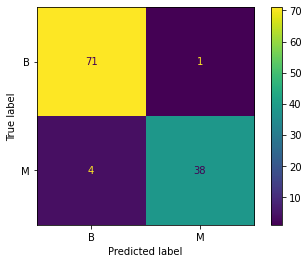

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

### Exercício

Vamos fazer a predição do dataset dos penguins novamente, fazendo a classificação por ilha (que não tinha performado tão bem)

1 - Instancie o Standard Scaler

2 - Faça o fit transform dos dados de treino e o transform dos dados de teste

3 - Faça o fit com os dados escalados, e o target não escalado

4 - Gere a predição com os dados de teste escalados

5 - Analise as metricas usando matriz de confusão e classification report

In [66]:
penguin = sns.load_dataset('penguins')

In [67]:
penguin

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


In [69]:
penguin = penguin.dropna()
penguin['sex'] = penguin['sex'].map({'Female': 0, 'Male': 1})

C:\Users\Inspira\AppData\Local\Temp/ipykernel_61252/1436322825.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  penguin['sex'] = penguin['sex'].map({'Female': 0, 'Male': 1})


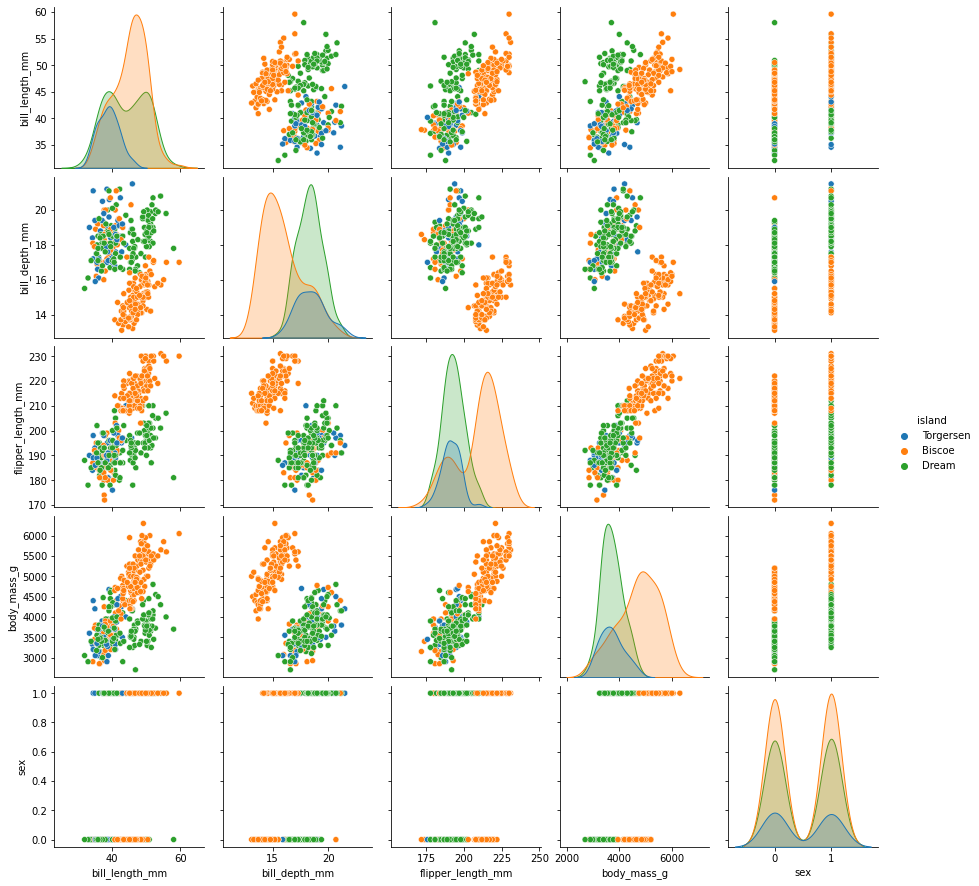

In [71]:
sns.pairplot(penguin, hue='island')

In [74]:
penguin['island'].value_counts(normalize=True)

Biscoe       0.489489
Dream        0.369369
Torgersen    0.141141
Name: island, dtype: float64

In [86]:
penguin

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,1
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,0
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,0
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,0
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,1
...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,0
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,0
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,1
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,0


In [87]:
X = penguin.drop(columns=['island', 'species'], axis=1)
y = penguin['island']

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42, stratify=y)

In [89]:
penguin_scaler = StandardScaler()

In [90]:
X_train_ss = penguin_scaler.fit_transform(X_train)

In [91]:
X_test_ss = penguin_scaler.transform(X_test)

In [105]:
knn_penguin = KNeighborsClassifier(n_neighbors=6)

In [106]:
knn_penguin.fit(X_train_ss, y_train)

KNeighborsClassifier(n_neighbors=6)

In [107]:
y_pred = knn_penguin.predict(X_test_ss)

In [108]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Biscoe       0.82      0.88      0.85        41
       Dream       0.80      0.90      0.85        31
   Torgersen       0.20      0.08      0.12        12

    accuracy                           0.77        84
   macro avg       0.61      0.62      0.60        84
weighted avg       0.72      0.77      0.74        84



In [101]:
y_pred

array(['Dream', 'Biscoe', 'Biscoe', 'Biscoe', 'Biscoe', 'Biscoe', 'Dream',
       'Torgersen', 'Biscoe', 'Dream', 'Biscoe', 'Biscoe', 'Biscoe',
       'Biscoe', 'Torgersen', 'Dream', 'Dream', 'Biscoe', 'Dream',
       'Biscoe', 'Dream', 'Dream', 'Biscoe', 'Dream', 'Biscoe', 'Biscoe',
       'Dream', 'Dream', 'Biscoe', 'Biscoe', 'Biscoe', 'Dream', 'Biscoe',
       'Biscoe', 'Torgersen', 'Dream', 'Biscoe', 'Biscoe', 'Dream',
       'Torgersen', 'Biscoe', 'Biscoe', 'Biscoe', 'Dream', 'Biscoe',
       'Dream', 'Dream', 'Dream', 'Biscoe', 'Biscoe', 'Biscoe', 'Biscoe',
       'Dream', 'Biscoe', 'Biscoe', 'Biscoe', 'Biscoe', 'Dream', 'Biscoe',
       'Dream', 'Dream', 'Torgersen', 'Dream', 'Dream', 'Dream', 'Biscoe',
       'Biscoe', 'Biscoe', 'Biscoe', 'Biscoe', 'Dream', 'Biscoe', 'Dream',
       'Biscoe', 'Torgersen', 'Biscoe', 'Dream', 'Biscoe', 'Dream',
       'Biscoe', 'Dream', 'Biscoe', 'Dream', 'Biscoe'], dtype=object)

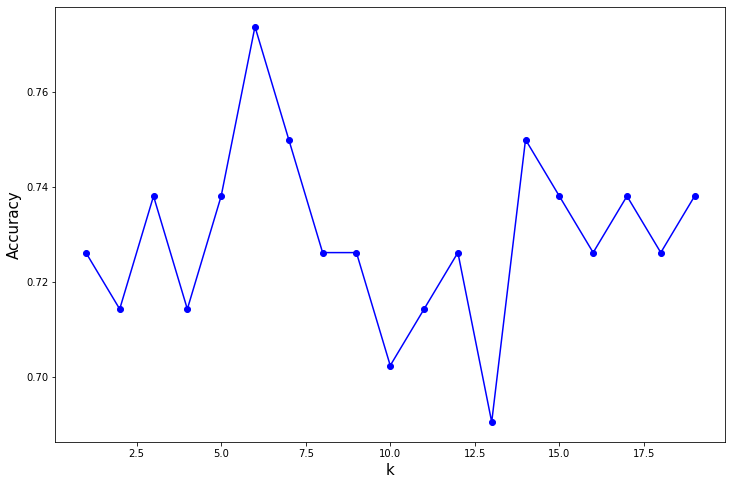

Melhor k: 6


In [104]:
from sklearn.metrics import accuracy_score

ks = []
accuracys = []

for k in range(1, 20):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_ss, y_train)
    y_pred = model.predict(X_test_ss)
    acc = accuracy_score(y_test, y_pred)
    accuracys.append(acc)
    ks.append(k)
    
plt.figure(figsize=(12,8))
plt.plot(ks, accuracys, '-bo')
plt.xlabel('k', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.show()
best_k = np.argmax(accuracys) + 1
print('Melhor k:', best_k)

## Outros Scalers

Outra opção é transformar os dados com o [min max scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) - **deixa o espaço amostral entre 0 e 1**

Aqui, as mesmas considerações sobre o método `.fit()` são válidas! (E pra qualquer outro transformer)

In [111]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler().fit(X_train)

X_train_mms = mms.transform(X_train)
X_test_mms = mms.transform(X_test)

In [112]:
X_train.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,...,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,14.166077,19.417692,92.215868,659.578242,0.095993,0.103835,0.089184,0.049015,0.181497,0.062715,...,16.351514,25.904879,107.860484,890.569231,0.132083,0.255529,0.275166,0.115491,0.291364,0.084124
std,3.579081,4.290653,24.717118,360.418686,0.014310,0.053910,0.081698,0.039686,0.027646,0.006971,...,4.901037,6.079532,34.176019,582.346181,0.023481,0.158400,0.212066,0.066844,0.063043,0.018169
min,6.981000,9.710000,43.790000,143.500000,0.062510,0.019380,0.000000,0.000000,0.106000,0.050240,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.710000,16.335000,75.235000,420.400000,0.085130,0.063735,0.029520,0.019685,0.162050,0.057635,...,13.020000,21.490000,84.135000,516.150000,0.114550,0.147750,0.119350,0.064075,0.251200,0.071365
50%,13.340000,18.900000,86.180000,546.400000,0.095240,0.092280,0.059400,0.033340,0.179900,0.061300,...,14.920000,25.480000,97.650000,683.400000,0.131100,0.216700,0.229800,0.101000,0.282300,0.080090
75%,15.935000,21.830000,104.500000,795.500000,0.104900,0.130350,0.132200,0.074075,0.195400,0.066370,...,19.185000,30.200000,127.000000,1122.500000,0.146600,0.338100,0.385700,0.162100,0.318700,0.092085
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [113]:
pd.DataFrame(X_train_mms, columns=X_train.columns).describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,...,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,0.340058,0.328295,0.334641,0.218909,0.331876,0.259048,0.208960,0.243611,0.381299,0.264297,...,0.299591,0.370066,0.286122,0.173361,0.402252,0.221439,0.219781,0.396875,0.265846,0.190763
std,0.169392,0.145102,0.170804,0.152882,0.141835,0.165359,0.191420,0.197246,0.139628,0.147682,...,0.174352,0.162034,0.170208,0.143125,0.155063,0.153680,0.169382,0.229704,0.124272,0.119170
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.223816,0.224045,0.217297,0.117455,0.224205,0.136050,0.069166,0.097838,0.283081,0.156674,...,0.181074,0.252399,0.167962,0.081338,0.286469,0.116871,0.095327,0.220189,0.186675,0.107077
50%,0.300961,0.310788,0.292931,0.170901,0.324413,0.223606,0.139175,0.165706,0.373232,0.234322,...,0.248666,0.358742,0.235271,0.122444,0.395760,0.183767,0.183546,0.347079,0.247979,0.164305
75%,0.423778,0.409875,0.419529,0.276564,0.420161,0.340378,0.309747,0.368166,0.451515,0.341737,...,0.400391,0.484542,0.381443,0.230363,0.498118,0.301549,0.308067,0.557045,0.319732,0.242982
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [128]:
pd.DataFrame(X_test_mms, columns=X_test.columns).describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,...,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000
mean,0.149702,-0.022093,0.164150,0.239333,0.130825,0.211380,0.271356,0.279430,-0.002288,0.209281,...,0.165550,-0.081677,0.168421,0.259465,0.075143,0.170835,0.114523,0.102791,0.039025,0.151828
std,0.782429,0.786782,0.773263,0.843715,0.657260,0.725878,0.697247,0.647510,0.795942,0.850658,...,0.739405,0.729266,0.728726,0.848869,0.626809,0.806928,0.731043,0.624811,0.843009,0.853619
min,-1.320710,-1.470428,-1.307364,-0.974140,-2.155286,-0.842753,-0.578496,-0.612980,-1.895052,-1.298226,...,-0.968045,-1.223881,-0.956491,-0.731096,-1.443370,-0.852377,-0.862775,-1.030349,-1.734815,-1.096525
25%,-0.410059,-0.578253,-0.400051,-0.355039,-0.328149,-0.338925,-0.278267,-0.210425,-0.550975,-0.281053,...,-0.331306,-0.674799,-0.316750,-0.284324,-0.324493,-0.377725,-0.487845,-0.359398,-0.575926,-0.395632
50%,0.021302,-0.111920,0.017085,0.031458,0.143146,0.066351,0.108590,0.031532,-0.089955,0.111620,...,0.008921,-0.139495,0.021579,0.015255,0.115445,-0.090097,-0.044115,-0.034379,-0.014815,-0.034990
75%,0.464497,0.416742,0.538869,0.450547,0.606222,0.583127,0.570462,0.673423,0.503748,0.522610,...,0.442011,0.363662,0.447335,0.466603,0.364275,0.663515,0.540830,0.602907,0.484815,0.568171
max,2.307692,2.469518,2.252520,3.027459,1.646940,2.237034,2.512661,2.258871,2.830585,3.943904,...,2.574209,2.288175,2.656013,3.461037,2.168487,3.761492,2.324010,1.562867,3.471111,3.113417


In [115]:
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train_mms, y_train)

y_pred_mms = knn.predict(X_test_mms)

y_pred_mms

array(['B', 'M', 'B', 'B', 'B', 'B', 'M', 'B', 'B', 'B', 'M', 'B', 'M',
       'B', 'B', 'B', 'B', 'B', 'M', 'B', 'B', 'B', 'M', 'M', 'M', 'B',
       'B', 'M', 'M', 'M', 'M', 'B', 'M', 'M', 'B', 'B', 'B', 'B', 'M',
       'B', 'B', 'B', 'B', 'B', 'B', 'M', 'B', 'M', 'B', 'B', 'M', 'M',
       'B', 'B', 'B', 'M', 'B', 'B', 'B', 'M', 'B', 'B', 'M', 'B', 'B',
       'B', 'M', 'M', 'B', 'M', 'B', 'M', 'M', 'B', 'B', 'B', 'B', 'M',
       'B', 'M', 'M', 'M', 'B', 'B', 'B', 'B', 'M', 'M', 'M', 'B', 'M',
       'B', 'B', 'B', 'B', 'B', 'B', 'M', 'B', 'B', 'B', 'B', 'B', 'B',
       'B', 'B', 'M', 'B', 'M', 'B', 'B', 'B', 'B', 'M'], dtype=object)

## Comparação

In [133]:
## Standard

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_ss))

              precision    recall  f1-score   support

           B       0.95      0.99      0.97        72
           M       0.97      0.90      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



In [132]:
## MM


from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_mms))

              precision    recall  f1-score   support

           B       0.95      0.99      0.97        72
           M       0.97      0.90      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



In [131]:
## RobustScaler

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train_rs, y_train)

y_pred_rs = knn.predict(X_test_rs)

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_rs))

              precision    recall  f1-score   support

           B       0.94      1.00      0.97        72
           M       1.00      0.88      0.94        42

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114



In [129]:
from sklearn.preprocessing import RobustScaler

rs = RobustScaler().fit(X_train)

X_train_rs = rs.transform(X_train)
X_test_rs = rs.transform(X_test)

Podemos testar também o [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html):

In [124]:
X_train.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,...,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,14.166077,19.417692,92.215868,659.578242,0.095993,0.103835,0.089184,0.049015,0.181497,0.062715,...,16.351514,25.904879,107.860484,890.569231,0.132083,0.255529,0.275166,0.115491,0.291364,0.084124
std,3.579081,4.290653,24.717118,360.418686,0.014310,0.053910,0.081698,0.039686,0.027646,0.006971,...,4.901037,6.079532,34.176019,582.346181,0.023481,0.158400,0.212066,0.066844,0.063043,0.018169
min,6.981000,9.710000,43.790000,143.500000,0.062510,0.019380,0.000000,0.000000,0.106000,0.050240,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.710000,16.335000,75.235000,420.400000,0.085130,0.063735,0.029520,0.019685,0.162050,0.057635,...,13.020000,21.490000,84.135000,516.150000,0.114550,0.147750,0.119350,0.064075,0.251200,0.071365
50%,13.340000,18.900000,86.180000,546.400000,0.095240,0.092280,0.059400,0.033340,0.179900,0.061300,...,14.920000,25.480000,97.650000,683.400000,0.131100,0.216700,0.229800,0.101000,0.282300,0.080090
75%,15.935000,21.830000,104.500000,795.500000,0.104900,0.130350,0.132200,0.074075,0.195400,0.066370,...,19.185000,30.200000,127.000000,1122.500000,0.146600,0.338100,0.385700,0.162100,0.318700,0.092085
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [125]:
pd.DataFrame(X_train_rs, columns=X_train.columns).describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,...,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,0.195521,0.094212,0.206249,0.301728,0.038085,0.173457,0.290069,0.288189,0.047890,0.161971,...,0.232200,0.048781,0.238201,0.341666,0.030672,0.203990,0.170326,0.147827,0.134278,0.194676
std,0.847120,0.780829,0.844597,0.960860,0.723808,0.809281,0.795656,0.729656,0.828973,0.798008,...,0.794978,0.697994,0.797294,0.960413,0.732642,0.832151,0.796194,0.681906,0.933976,0.876865
min,-1.505089,-1.672429,-1.448488,-1.074114,-1.655539,-1.094348,-0.578496,-0.612980,-2.215892,-1.266171,...,-1.133820,-1.545350,-1.102065,-0.821638,-1.869891,-0.995062,-0.862775,-1.030349,-1.863704,-1.208977
25%,-0.385799,-0.466788,-0.373996,-0.335910,-0.511381,-0.428507,-0.291001,-0.251057,-0.535232,-0.419576,...,-0.308191,-0.458094,-0.315292,-0.275831,-0.516381,-0.362227,-0.414680,-0.376690,-0.460741,-0.421091
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.614201,0.533212,0.626004,0.664090,0.488619,0.571493,0.708999,0.748943,0.464768,0.580424,...,0.691809,0.541906,0.684708,0.724169,0.483619,0.637773,0.585320,0.623310,0.539259,0.578909
max,3.495858,3.708826,3.496327,5.210877,3.447648,3.799745,3.578107,3.086229,3.721139,4.137378,...,3.425791,2.762342,3.582177,5.888678,2.854914,4.419753,3.837807,1.938281,5.651852,6.149131


Agora sim, estamos prontos para treinar e avaliar o modelo, com as features escaladas!

Classe: [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

[[71  1]
 [ 4 38]]


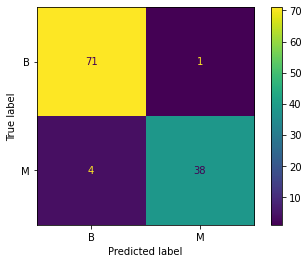

              precision    recall  f1-score   support

           B       0.95      0.99      0.97        72
           M       0.97      0.90      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114


# ====================

[[284   1]
 [  9 161]]


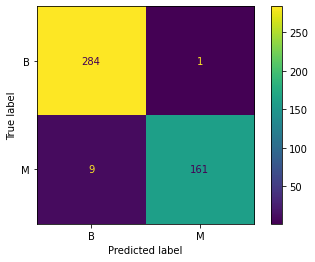

              precision    recall  f1-score   support

           B       0.97      1.00      0.98       285
           M       0.99      0.95      0.97       170

    accuracy                           0.98       455
   macro avg       0.98      0.97      0.98       455
weighted avg       0.98      0.98      0.98       455



In [134]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# ====================

df = pd.read_csv("breast_cancer.csv")

X = df.drop(columns="diagnosis")
y = df["diagnosis"]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42,
                                                    stratify=y)
# ====================

ss = StandardScaler().fit(X_train)

X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

# ====================

knn = KNeighborsClassifier().fit(X_train_ss, y_train)

# ====================

y_pred_test = knn.predict(X_test_ss)

print(confusion_matrix(y_test, y_pred_test))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()

print(classification_report(y_test, y_pred_test))

print("\n# ====================\n")

y_pred_train = knn.predict(X_train_ss)

print(confusion_matrix(y_train, y_pred_train))

ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
plt.show()

print(classification_report(y_train, y_pred_train))

Entendendo a classificação

In [36]:
# vamos pegar a primeira observação de teste, como exemplo
X_test_ss[0]

array([-0.24307384, -0.77089916, -2.00602473, -0.76451652, -0.71183971,
       -0.1583148 , -0.68680034, -0.66248612, -0.57475415, -0.53582061,
       -0.22760708, -0.93280815, -1.37244026, -0.85278289, -0.6368401 ,
       -0.2999339 , -0.56993036, -0.53250895, -0.83258923, -0.8416237 ,
       -0.59337276, -0.72135781, -1.63595077, -0.70654903, -0.65337009,
        0.96851866, -0.10446758, -0.30668651, -0.38805702,  0.16254727,
        0.06095804])

In [138]:
knn.predict(X_test_ss[0].reshape(1, -1))

array(['B'], dtype=object)

In [139]:
knn.kneighbors(X_test_ss[0].reshape(1, -1))

(array([[1.59659162, 1.91559863, 2.00607687, 2.0694831 , 2.07061232]]),
 array([[236, 164, 428,  98,  34]], dtype=int64))

In [39]:
X_train.iloc[[236, 164, 428,  98,  34]]

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
271,8910748,11.29,13.04,72.23,388.0,0.09834,0.07608,0.03265,0.02755,0.1769,...,12.32,16.18,78.27,457.5,0.1358,0.1507,0.12750,0.08750,0.2733,0.08022
48,857155,12.05,14.63,78.04,449.3,0.10310,0.09092,0.06592,0.02749,0.1675,...,13.76,20.70,89.88,582.6,0.1494,0.2156,0.30500,0.06548,0.2747,0.08301
527,91813702,12.34,12.27,78.94,468.5,0.09003,0.06307,0.02958,0.02647,0.1689,...,13.61,19.27,87.22,564.9,0.1292,0.2074,0.17910,0.10700,0.3110,0.07592
158,871122,12.06,12.74,76.84,448.6,0.09311,0.05241,0.01972,0.01963,0.1590,...,13.14,18.41,84.08,532.8,0.1275,0.1232,0.08636,0.07025,0.2514,0.07898
390,90317302,10.26,12.22,65.75,321.6,0.09996,0.07542,0.01923,0.01968,0.1800,...,11.38,15.65,73.23,394.5,0.1343,0.1650,0.08615,0.06696,0.2937,0.07722


In [40]:
y_train.iloc[[236, 164, 428,  98,  34]]

271    B
48     B
527    B
158    B
390    B
Name: diagnosis, dtype: object

## Exercício

Utilize o dataset de Insurance com as categorias criadas abaixo, faça o treinamento do K vizinhos para as classes escolhidas usando os Scalers que acabamos de conhecer e compare a performance

### Passo a passo

1 - Escolha um Scaler e faça o instanciamento

2 - Faça o fit transform dos dados de treino e o transform dos dados de teste

3 - Faça o fit com os dados escalados, e o target não escalado

4 - Gere a predição com os dados de teste escalados

5 - Analise as metricas usando matriz de confusão e classification report

In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [150]:
df = pd.read_csv("../datasets/insurance.csv")

In [151]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [152]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [153]:
df['target'] = np.where(df['charges'] < 10000, 0, np.where(df['charges'] < 30000, 1, 2))

In [154]:
## Cuidado com o vazamento

df.drop(['charges'], axis=1)

,age,sex,bmi,children,smoker,region,target
0,19,female,27.900,0,yes,southwest,1
1,18,male,33.770,1,no,southeast,0
2,28,male,33.000,3,no,southeast,0
3,33,male,22.705,0,no,northwest,1
4,32,male,28.880,0,no,northwest,0
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,1
1334,18,female,31.920,0,no,northeast,0
1335,18,female,36.850,0,no,southeast,0
1336,21,female,25.800,0,no,southwest,0


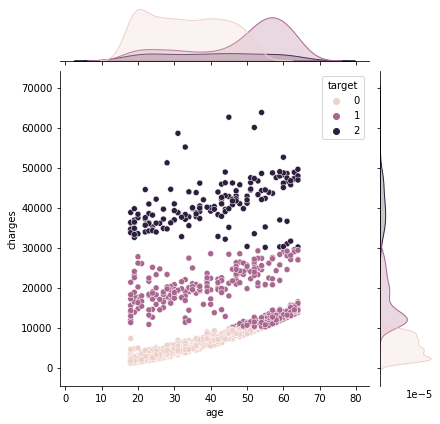

In [155]:
sns.jointplot(data=df, x='age', y='charges', hue='target')

In [ ]:
## Você continua a partir daqui!

## Validação cruzada no KNN

__________

Vamos fazer também a validação cruzada!

Mas uma importante alteração é necessária... Se fizermos como antes, usando o target original diretamente:

```python
from sklearn.model_selection import KFold, cross_validate

grupo = KFold(n_splits=10, shuffle=True, random_state=42)

metrica = "f1"

results = cross_validate(estimator=estimador,
                         X=X_train, y=y_train,
                         cv=grupo,
                         scoring=metrica,
                         return_train_score=True)
```
Teremos um erro (teste!)

In [130]:
from sklearn.model_selection import KFold, cross_validate

In [156]:
df = pd.read_csv("breast_cancer.csv")

X = df.drop(columns="diagnosis")
y = df["diagnosis"]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42,
                                                    stratify=y)
# ====================

ss = StandardScaler().fit(X_train)

X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

# ====================

estimador = KNeighborsClassifier()

# ====================

grupo = KFold(n_splits=10, shuffle=True, random_state=42)

metrica = "f1"

results = cross_validate(estimator=estimador,
                         X=X_train, y=y_train,
                         cv=grupo,
                         scoring=metrica,
                         return_train_score=True)

C:\Users\Inspira\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Inspira\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Inspira\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\Inspira\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Inspira\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "C:\Users\Inspira\AppData\Roaming\Python\Python39\site-pack

C:\Users\Inspira\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Inspira\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Inspira\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\Inspira\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\Inspira\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "C:\Users\Inspira\AppData\Roaming\Python\Python39\site-pack

In [132]:
df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


Não há problema algum em utilizar as classes originais quando deseja-se avaliar o modelo final com a matriz de confusão ou o classification_report. Internamente, é feita um mapeamento pra 0 e 1.

Mas, pra usar o cross_validate, este mapa não é feito. Daí, é necessário que seja explicitamente indicada este mapeamento. Pra fazer isso, há duas opções:

- 1 - Fazer o mapeamento explicitamente e depois usar o código extamente como acima;
- 2 - Indicar qual é a classe positiva (valor 1) na hora de indicar a métrica a ser calculada -- mas pra isso, a função respectiva da métrica deve ser usada, junto com o argumento `pos_label`

Vejamos ambas as opções:

In [133]:
y.map({"M":1, "B":0})

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: diagnosis, Length: 569, dtype: int64

In [159]:
df = pd.read_csv("breast_cancer.csv")

X = df.drop(columns="diagnosis")
y = df["diagnosis"]

# ====================
# alterando o target

y_num = y.map({"M":1, "B":0})

# ====================

X_train, X_test, y_train, y_test = train_test_split(X, y_num, 
                                                    test_size=0.2, random_state=42,
                                                    stratify=y)
# ====================

ss = StandardScaler().fit(X_train)

X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

# ====================

estimador = KNeighborsClassifier()

# ====================

grupo = KFold(n_splits=10, shuffle=True, random_state=42)

metrica = "recall"

results = cross_validate(estimator=estimador,
                         X=X_train_ss, y=y_train,
                         cv=grupo,
                         scoring=metrica,
                         return_train_score=True)

results_cv =pd.DataFrame(results)

In [160]:
results_cv.describe()

,fit_time,score_time,test_score,train_score
count,10.000000,10.000000,10.000000,10.000000
mean,0.000900,0.002800,0.909533,0.944393
std,0.001198,0.000788,0.066603,0.006703
min,0.000000,0.002001,0.750000,0.933775
25%,0.000000,0.002002,0.900000,0.940294
50%,0.000997,0.002995,0.904545,0.946667
75%,0.001000,0.003000,0.949342,0.949606
max,0.004001,0.004002,1.000000,0.952381


Segunda forma, só indicando o que é a classe positiva:

In [179]:
df = pd.read_csv("breast_cancer.csv")

X = df.drop(columns="diagnosis")
y = df["diagnosis"]

# ====================

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42,
                                                    stratify=y)
# ====================

ss = StandardScaler().fit(X_train)

X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

# ====================

estimador = KNeighborsClassifier()

# ====================

grupo = KFold(n_splits=10, shuffle=True, random_state=42)


from sklearn.metrics import make_scorer, f1_score, recall_score

metrica = make_scorer(recall_score, pos_label="M")

results = cross_validate(estimator=estimador,
                         X=X_train_ss, y=y_train,
                         cv=grupo,
                         scoring=metrica,
                         return_train_score=True)

pd.DataFrame(results).describe()

,fit_time,score_time,test_score,train_score
count,10.000000,10.000000,10.000000,10.000000
mean,0.000953,0.002700,0.909533,0.944393
std,0.000373,0.000483,0.066603,0.006703
min,0.000000,0.001999,0.750000,0.933775
25%,0.001000,0.002250,0.900000,0.940294
50%,0.001000,0.002999,0.904545,0.946667
75%,0.001000,0.002999,0.949342,0.949606
max,0.001525,0.003001,1.000000,0.952381


Discutimos que o recall da classe "M" é o que queremos otimizar. Então, vamos, antes de tudo, fazer a CV pra essa métrica:

In [140]:
df = pd.read_csv("breast_cancer.csv")

X = df.drop(columns="diagnosis")
y = df["diagnosis"]

# ====================

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42,
                                                    stratify=y)
# ====================

ss = StandardScaler().fit(X_train)

X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

# ====================

estimador = KNeighborsClassifier()

# ====================

grupo = KFold(n_splits=10, shuffle=True, random_state=42)

from sklearn.metrics import make_scorer, recall_score

metrica = make_scorer(recall_score, pos_label="M")

results = cross_validate(estimator=estimador,
                         X=X_train_ss, y=y_train,
                         cv=grupo,
                         scoring=metrica,
                         return_train_score=True)

df_results = pd.DataFrame(results)

In [47]:
df_results

,fit_time,score_time,test_score,train_score
0,0.001000,0.007451,0.900000,0.950000
1,0.000000,0.000000,0.956522,0.952381
2,0.000000,0.000000,0.950000,0.946667
3,0.002002,0.003994,1.000000,0.934211
4,0.001062,0.000000,0.909091,0.949686
5,0.000000,0.003997,0.900000,0.940000
6,0.000981,0.004016,0.900000,0.946667
7,0.000000,0.000000,0.882353,0.941176
8,0.000000,0.000000,0.750000,0.949367
9,0.000000,0.003997,0.947368,0.933775


In [48]:
df_results.describe()

,fit_time,score_time,test_score,train_score
count,10.000000,10.000000,10.000000,10.000000
mean,0.000504,0.002345,0.909533,0.944393
std,0.000711,0.002678,0.066603,0.006703
min,0.000000,0.000000,0.750000,0.933775
25%,0.000000,0.000000,0.900000,0.940294
50%,0.000000,0.001997,0.904545,0.946667
75%,0.000995,0.003997,0.949342,0.949606
max,0.002002,0.007451,1.000000,0.952381


O modelo não teve uma performance muito ruim, mas podemos melhorar! Afinal, um modelo de tamanha importância não pode ter uma margem de erro muito grande, não é mesmo?

Vamos iniciar o ciclo de melhorias para ver se conseguimos melhorar a performance do modelo, em um processo que é muitas vezes chamado de **tunning**


**Novamente:** treine os scalers **apenas nos dados de treino** para evitar que informação dos dados de teste sejam passadas para o scaler! (Mais informações [aqui](https://datascience.stackexchange.com/questions/38395/standardscaler-before-and-after-splitting-data))

In [180]:
y_test = y_test.map({'M':1, 'B':0})
y_train = y_train.map({'M':1, 'B':0})

In [182]:
y_train.value_counts()

0    285
1    170
Name: diagnosis, dtype: int64

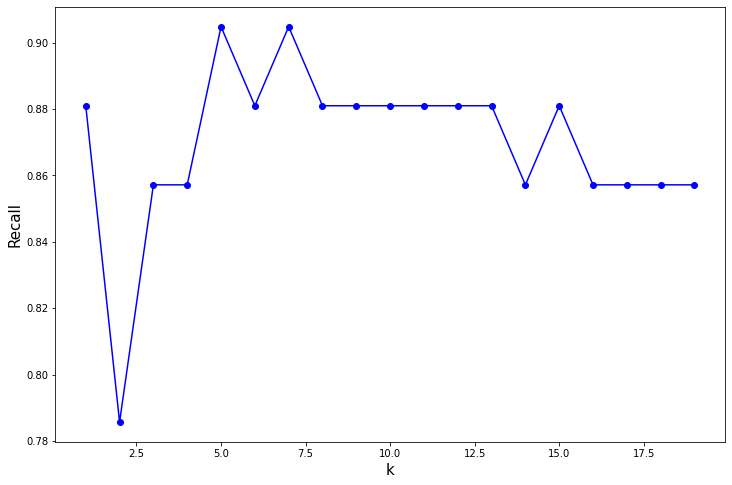

Melhor k: 5


In [183]:
from sklearn.metrics import recall_score

ks = []
recall = []

for k in range(1, 20):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_ss, y_train)
    y_pred = model.predict(X_test_ss)
    rec = recall_score(y_test, y_pred)
    recall.append(rec)
    ks.append(k)
    
plt.figure(figsize=(12,8))
plt.plot(ks, recall, '-bo')
plt.xlabel('k', fontsize = 15)
plt.ylabel('Recall', fontsize = 15)
plt.show()
best_k = np.argmax(recall) + 1
print('Melhor k:', best_k)

Observe como a performance do modelo mudou!

Mas será que é possível melhorar ainda mais? Na aula que vem vamos agora aprender como é possível testar diferentes parâmetros de uma única vez!